<a href="https://colab.research.google.com/github/DiGyt/neuropynamics/blob/DiGyt_dev/notebooks/multineuron_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

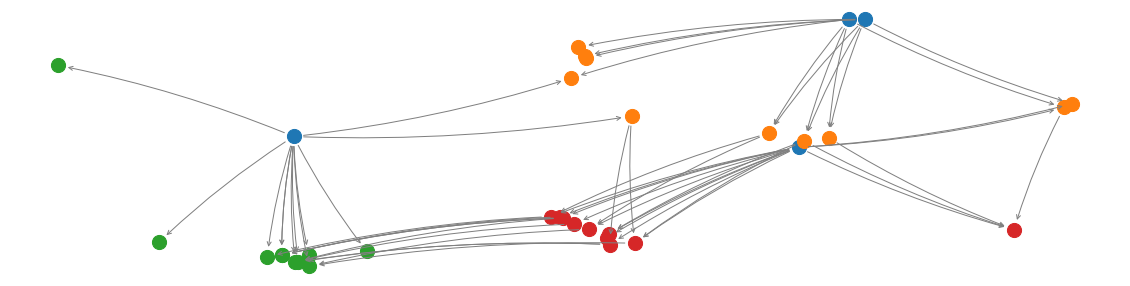

# **Simulating Multineuron Networks**

In this notebook, we will find out how to simulate larger networks using brian2 along with the plotting functions that we provide with the neuropynamics repository.

## Install/ Import

First of all, we have to install brian2 again, as well as cloning the neuropynamics repository in order to import the plotting functions.

In [2]:
!pip install brian2
!git clone https://github.com/DiGyt/neuropynamics/ --branch DiGyt_dev

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 5.8MB 11.3MB/s 
  Created wheel for brian2: filename=Brian2-2.3.0.2-cp36-cp36m-linux_x86_64.whl size=1283455 sha256=ed4a793b5f410a4aff266bdf2d69ef6c61c3f5737115f800c47a7936c77b24d6
  Stored in directory: /root/.cache/pip/wheels/86/b5/f6/0c8f9eec58c01e4af55a4c79a5e0385aea01ed03e4ec36c4ac
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1
Cloning into 'neuropynamics'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 213 (delta 76), reused 66 (delta 7), pack-reused 0
Receiving objects: 100% (213/213), 1.97 MiB | 2.15 MiB/s, done.
Resolving deltas: 100% (76/76), done.


Now we can import all the objects/functions that we need for our notebook.

In [3]:
from neuropynamics.src.plotting import (plot_signals, plot_cmesh, plot_spikes, plot_synapses)
from brian2 import mV, ms, volt, second
from brian2 import (start_scope, NeuronGroup, Synapses, PoissonGroup,
                    StateMonitor, SpikeMonitor, run)
import networkx as nx
import numpy as np

/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


## Build a large connected network

First of all, we will define a Poisson neuron group that produce random spikes from a poisson process. To visualize the spiking process, we will plot them.

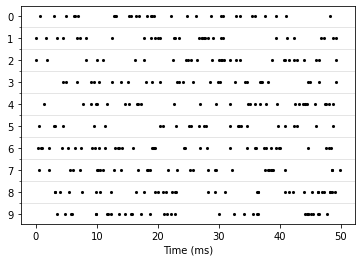

In [4]:
# start brian2 scope
start_scope()

# we want 10 neurons to fire 700 times per second on average
poisson_inp = PoissonGroup(10, rates=700/second)

# run a simulation for 50 ms while monitoring the spikes
poisson_spikes = SpikeMonitor(poisson_inp, record=True)
run(50*ms)

# plot them
plot_spikes(poisson_spikes.i, poisson_spikes.t/ms, time_unit="ms")

Now we can build up a larger neuron network including Poisson generated inputs and differently tuned Izhikevich neurons.

For this, we will create two brian2 Neurongroups. one will be tuned as regularly spiking Izhikevich neurons, the other as chattering Izhikevich neurons. Then we will create multiple synapse groups, connecting the Poisson spiking Input with the two neuron groups, as well as connecting these with each other. After this, we will simply run and simulate this network for some time (while recording the responses).

In [5]:
# start brian2 scope
start_scope()

# define the number of neurons for both groups
N_regular = 10
N_chattering = 10

# define the average poisson input spiking rate
input_rate = 300/second

# start creating Izhikevich neurons based on our known Izhikevich model
model = '''dvm/dt = (0.04/ms/mV)*vm**2+(5/ms)*vm+140*mV/ms-w + I : volt
dw/dt = a*(b*vm-w) : volt/second
c : volt
d : volt/second'''
threshold = 'vm > 35*mV'
reset = 'vm = c; w += d'
a = 0.02/ms; b = 0.2/ms; I = 0*volt/second

# create regularly spiking izhikevich neurons
iz_regular = NeuronGroup(N_regular, model=model, threshold=threshold,
                         reset=reset, method='euler', name='Regular')
iz_regular.c = -65*mV
iz_regular.d = 8*volt/second

# create chattering izhikevich neurons
iz_chattering = NeuronGroup(N_chattering, model=model, threshold=threshold,
                            reset=reset, method='euler', name='Chattering')
iz_chattering.c = -50*mV
iz_chattering.d = 2*volt/second

# generate poisson input spikes of the same number as regular neurons
N_poisson = N_regular
poisson_inp = PoissonGroup(N_poisson, rates=input_rate, name='Input')


# now, introduce synapses between the neurons
# start with synapses from the input to the regular neurons
syn_0 = Synapses(poisson_inp, iz_regular, 'weight : volt', on_pre='vm_post += weight')
syn_0.connect(i=np.arange(0, N_poisson),
              j=np.arange(0, N_regular))
syn_0.delay =  1 * ms
syn_0.weight = 30 * mV

# inputs to chattering
syn_1 = Synapses(poisson_inp, iz_chattering, 'weight : volt', on_pre='vm_post += weight')
syn_1.connect(i=np.random.randint(0, N_poisson, N_chattering),
              j=np.arange(0, N_chattering))
syn_1.delay =  1 * ms
syn_1.weight = 30 * mV

# random synapses from regular to chattering
N_synapses = N_chattering
syn_2 = Synapses(iz_regular, iz_chattering, 'weight : volt', on_pre='vm_post += weight')
syn_2.connect(i = np.random.randint(0, N_regular, N_synapses),
              j = np.random.randint(0, N_chattering, N_synapses))
syn_2.delay =  np.random.randint(1, 12, N_synapses) * ms
syn_2.weight = 30 * mV

# random synapses from chattering to regular
N_synapses = N_regular // 2
syn_3 = Synapses(iz_chattering, iz_regular, 'weight : volt', on_pre='vm_post += weight')
syn_3.connect(i = np.random.randint(0, N_chattering, N_synapses),
              j = np.random.randint(0, N_regular, N_synapses))
syn_3.delay =  np.random.randint(1, 12, N_synapses) * ms
syn_3.weight = 30 * mV

# define which neurons to record
regular_states = StateMonitor(iz_regular, 'vm', record=True)
chattering_states = StateMonitor(iz_chattering, 'vm', record=True)
poisson_spikes = SpikeMonitor(poisson_inp, record=True)

# run the simulation
run(100*ms)

## Visualize the Network

Now we can plot the above defined network of neurons and synapses, using our neuropynamics synapse plotting function (which is based on the networkx graph theory toolbox).


If you want to change some aspects of the graph visualization, you can check out different graph layouts here:

[https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout](https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout)

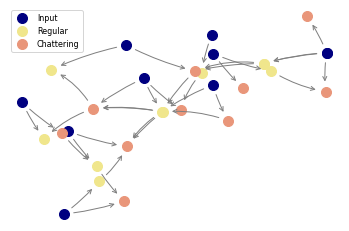

In [6]:
plot_synapses([poisson_inp, iz_regular, iz_chattering],
              [syn_0, syn_1, syn_2, syn_3],
              pos_func=nx.kamada_kawai_layout,
              color_cycle=["navy", "khaki", "darksalmon"],
              legend="best", node_size=100)



We can visualize the membrane potential of each neuron as a channel-wise plot. Using this plotting function, we can visualize any variable recorded with a brian2 StateMonitor.

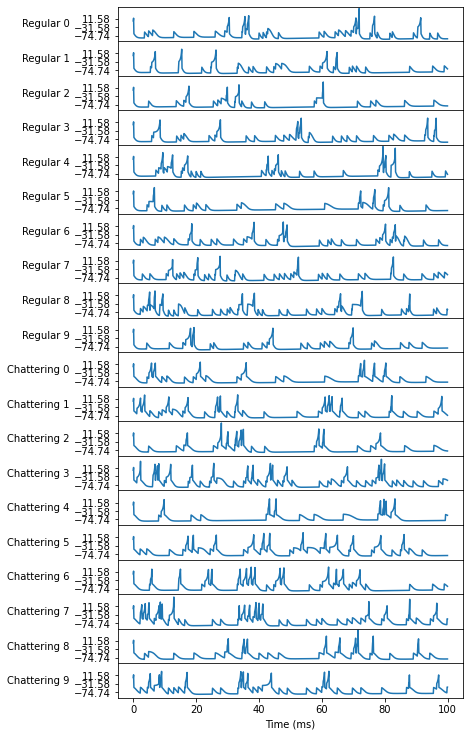

In [7]:
# stack up the recorded variables from both our regular and chattering neurons
states = np.vstack([regular_states.vm/mV,
                    chattering_states.vm/mV])

# define group-specific names for the neurons
names = np.hstack([["Regular " + str(i) for i in range(N_regular)],
                   ["Chattering " + str(i) for i in range(N_chattering)]])

# plot them using the neuropynamics plot_signals function
plot_signals(states, regular_states.t/ms, names, spacing=0.12, time_unit="ms")

We can plot the spiking times of a brian2 SpikeMonitor using the plot_spikes function. Like this, we can again visualize the spikes of our PoissonGroup Input spikes.

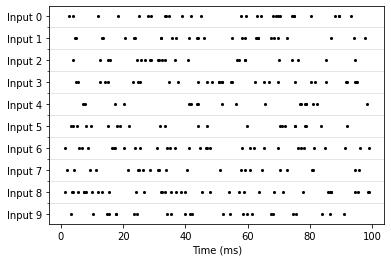

In [8]:
# Define some specific names for the input
inp_names = ["Input " + str(i) for i in range(N_regular)]

# plot them
plot_spikes(poisson_spikes.i, poisson_spikes.t/ms, inp_names, time_unit="ms")

As a more comprehensive plot, we can use plt_cmesh to plot the membrane potential (or other StateMonitor-recorded variables). This function is especially helpful when plotting a large number of neurons (as it works faster).

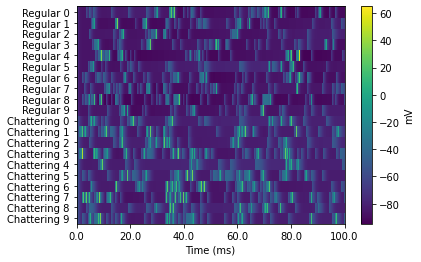

In [9]:
plot_cmesh(states, regular_states.t/ms, names, unit="mV", time_unit="ms")